In [17]:
import sys
sys.path.insert(1, sys.path[0]+'/../qiskit/providers/aer/')
sys.path.insert(1, sys.path[0]+'/../')

from matplotlib import pyplot as plt
import numpy as np
from qiskit.quantum_info.operators import Operator
from pulse_new.models.signals import VectorSignal, Constant,  Signal
from pulse_new.models.operator_models import OperatorModel

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

# 1. Basic functionality

In [18]:
r = 0.02
w = 5.
signals = [Constant(1.), Signal(1., w)]
operators = [-1j * 2 * np.pi * w * Z/2, -1j * 2 * np.pi * r * X/2]

model = OperatorModel(operators=operators, signals=signals)

Evaluate at a given time.

In [19]:
print(model.evaluate(0.3))
print(model.evaluate(1.))

[[0.-15.70796327j 0. +0.06283185j]
 [0. +0.06283185j 0.+15.70796327j]]
[[0.-15.70796327j 0. -0.06283185j]
 [0. -0.06283185j 0.+15.70796327j]]


Get the drift (terms corresponding to `Constant` coefficients). In this case just the first term.

In [20]:
model.drift

array([[0.-15.70796327j, 0. +0.j        ],
       [0. +0.j        , 0.+15.70796327j]])

In [24]:
%time model.lmult(1., np.array([1., 0.]), in_frame_basis=True)

CPU times: user 171 µs, sys: 10 µs, total: 181 µs
Wall time: 178 µs


array([0.-15.70796327j, 0. -0.06283185j])

# 2. Enter a frame

In this case, we will enter the frame of the drift.

In [6]:
model.frame = model.drift

Evaluate again.

In [7]:
print(model.evaluate(0.1))
print(model.evaluate(0.2))

[[ 0.00000000e+00+0.j         -7.69468277e-18-0.06283185j]
 [ 7.69468277e-18-0.06283185j  0.00000000e+00+0.j        ]]
[[ 0.00000000e+00+0.j         -1.53893655e-17-0.06283185j]
 [ 1.53893655e-17-0.06283185j  0.00000000e+00+0.j        ]]


In [8]:
%time model.lmult(1., np.array([1., 0.]), in_frame_basis=True)

CPU times: user 222 µs, sys: 22 µs, total: 244 µs
Wall time: 233 µs


array([ 0.00000000e+00+0.j        , -7.69468277e-17-0.06283185j])

In the above, the diagonal part of the model is now $0$, as it has been subtracted when entering the frame (which is coincidentally the diagonal). The off-diagonal part, which ordinarily is $-i 2 \pi r X / 2$ multiplied with an oscillating signal, is now rotating between $-iX$ and $-iY$ as a result of being in the frame. We can plot the real and imaginary parts of the first off-diagonal to see this.

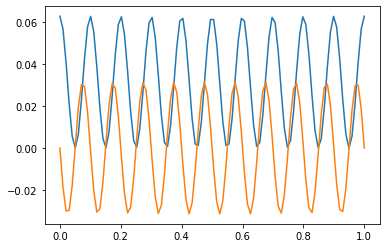

In [9]:
t_vals = np.linspace(0., 1., 100)
model_vals = np.array([model.evaluate(t) for t in t_vals])
offdiag_re = -model_vals[:, 0, 1].real
offdiag_im = -model_vals[:, 0, 1].imag
plt.plot(t_vals, offdiag_im)
plt.plot(t_vals, offdiag_re)

In the above, the imaginary part is blue, corresponding to the $X$ operator, and the real part is yellow, corresponding to the $Y$ operator. (Note, usually which is imaginary and which is real is swapped, but in this case our `OperatorModel` is defined as the generator of the Schrodinger equation, so everything has a factor of $-i$.

# 3. Set cutoff frequency

Next, we add a cutoff frequency, which eliminates terms in the model oscillating above a given frequency. The frequencies for a given term are a combination of oscillations due to the chosen frame, as well as oscillations due to signal carrier frequencies.

The classic RWA uses the model we have defined, and sets the cutoff to `2*w`.

In [10]:
model.cutoff_freq = 2*w

We now perform the same plot as above.

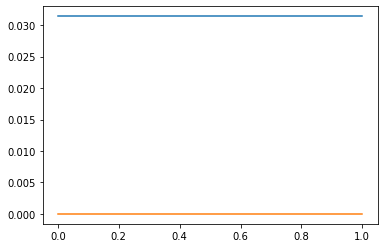

In [11]:
t_vals = np.linspace(0., 1., 100)
model_vals = np.array([model.evaluate(t) for t in t_vals])
offdiag_re = -model_vals[:, 0, 1].real
offdiag_im = -model_vals[:, 0, 1].imag
plt.plot(t_vals, offdiag_im)
plt.plot(t_vals, offdiag_re)

Observe, the real part is now constant at $-\pi /2$, which is the average of the oscillation in the previous section (similarly, the imaginary part is constant at the corresponding average of $0$).

# 4. Adding a `signal_mapping`

A `signal_mapping` attribute is meant to be a function that generates the signals from a list of parameters. E.g. for a model involving transfer functions, the action of the transfer functions would be included in `signal_mapping`, and the user would specify the pre-filter signals to the model, which would automatically apply the mapping.

In [12]:
# instantiate without signals but with a signal mapping
r = 1.
w = 1.
operators = [-1j * 2 * np.pi * w * Z/2, -1j * 2 * np.pi * r * X/2]

def signal_map(slope):
    return [Constant(1.), Signal(lambda t: t* slope, w)]

model = OperatorModel(operators=operators, signal_mapping=signal_map)

In [13]:
# now, setting signals will automatically feed the passed values through signal_mapping
model.signals = 1.
print(model._signal_params)
print(model.signals)

1.0


We can plot the X and Y coefficients with no specified frame.

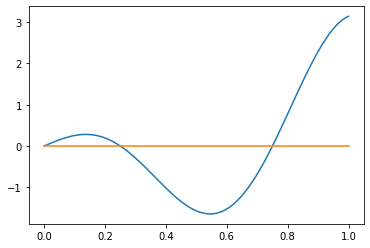

In [14]:
t_vals = np.linspace(0., 1., 100)
model_vals = np.array([model.evaluate(t) for t in t_vals])
offdiag_re = -model_vals[:, 0, 1].real
offdiag_im = -model_vals[:, 0, 1].imag
plt.plot(t_vals, offdiag_im)
plt.plot(t_vals, offdiag_re)

The X and Y coefficients in the rotating frame of the drift:

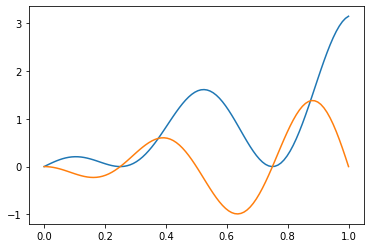

In [15]:
# plot in the drift frame
model.frame = model.drift
t_vals = np.linspace(0., 1., 100)
model_vals = np.array([model.evaluate(t) for t in t_vals])
offdiag_re = -model_vals[:, 0, 1].real
offdiag_im = -model_vals[:, 0, 1].imag
plt.plot(t_vals, offdiag_im)
plt.plot(t_vals, offdiag_re)

The X and Y coefficients in the rotating frame after the standard RWA:

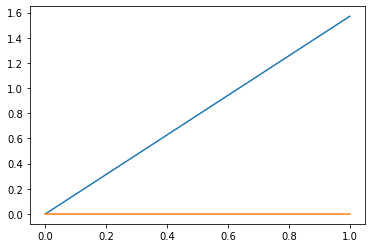

In [16]:
# plot again with cutoff
model.cutoff_freq = 2*w
t_vals = np.linspace(0., 1., 100)
model_vals = np.array([model.evaluate(t) for t in t_vals])
offdiag_re = -model_vals[:, 0, 1].real
offdiag_im = -model_vals[:, 0, 1].imag
plt.plot(t_vals, offdiag_im)
plt.plot(t_vals, offdiag_re)